# Muscle Activation in Normal and Abnormal Subjects

## Description

This project processes EMG data from **22 subjects** (11 Normal, 11 Abnormal) performing three exercises—**March** (`mar`, walking), **Extension** (`pie`, “de pie” / standing straight), and **Flexion** (`sen`, “sentarse” / sit-to-stand)—to quantify muscle activation across five channels (Recto Femoral, Biceps Femoral, Vasto Medial, Semitendinoso, Flexo-Extension angle).

After downloading and merging all individual `.log` / `.txt` files, we generate per-subject graphs of each muscle’s activation during each exercise, plus overlaid dot-range and line-mean plots comparing Normal vs. Abnormal for each muscle × exercise (with interquartile ranges).

Finally, we build and evaluate classifiers (**Logistic Regression**, **SVM**, **KNN**, **Random Forest**) to distinguish Normal/Abnormal subjects—both per exercise and via ensemble **voting** and **stacking** classifiers—leveraging the label codes (`mar` = March, `pie` = Extension, `sen` = Flexion, plus `n` / `a` for Normal / Abnormal).

The goal is to determine whether a person’s muscle activation during physical activity resembles a **normal or abnormal movement pattern**. This kind of analysis can support **early detection of neuromuscular issues**, guide **rehabilitation progress**, or even **optimize athletic training**.

## Author

Darren McCauley

## Date

May 2025


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving SEMG_DB1.rar to SEMG_DB1.rar


In [ ]:
!apt-get install unrar
!unrar x SEMG_DB1.rar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from SEMG_DB1.rar

Creating    A_LOG                                                     OK
Extracting  A_LOG/10Amar.log                                               0%  OK 
Extracting  A_LOG/10Apie.log                                               0%  1%  OK 
Extracting  A_LOG/10Asen.log                                               1%  OK 
Extracting  A_LOG/11Amar.log                                               1%  2%  OK 
Extracting  A_LOG/11Apie.log                                               2%  OK 
Extracting  A_LOG/11Asen.log                                               3%  OK 
Extracting  A_LOG/1Amar.log       

In [ ]:
import pandas as pd
import glob
import os
import re

# === Function to parse each file ===
def parse_file(file_path, label):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines[7:]:  # Skipping metadata
        parts = line.strip().split()
        if len(parts) == 5:
            try:
                row = list(map(float, parts))
                data.append(row)
            except ValueError:
                continue  # Skipping rows with invalid numbers

    if not data:
        return None  # Skipping empty files

    df = pd.DataFrame(data, columns=[
        'Recto Femoral', 'Biceps Femoral', 'Vasto Medial',
        'EMG Semitendinoso', 'Flexo-Extension'
    ])
    df['filename'] = os.path.basename(file_path)
    df['Label'] = label
    return df

# === Getting file paths ===
abnormal_files = glob.glob('/content/A_TXT/*.txt')
normal_files   = glob.glob('/content/N_TXT/*.txt')

# === Storing dataframes ===
dfs = []

for file_path in abnormal_files:
    df = parse_file(file_path, 'Abnormal')
    if df is not None:
        dfs.append(df)

for file_path in normal_files:
    df = parse_file(file_path, 'Normal')
    if df is not None:
        dfs.append(df)

# === Combining into one DataFrame ===
if not dfs:
    raise ValueError("No dataframes were created. Check your file paths or file contents.")
final_df = pd.concat(dfs, ignore_index=True)

# === Extracting Subject and Exercise type ===
def extract_meta(filename):
    subject_match = re.match(r'(\d+)', filename)
    subject = int(subject_match.group(1)) if subject_match else None

    filename_lower = filename.lower()
    if 'mar' in filename_lower:
        exercise = 'March'
    elif 'sen' in filename_lower:
        exercise = 'Extension'
    elif 'pie' in filename_lower:
        exercise = 'Flexion'
    else:
        exercise = 'Unknown'

    return pd.Series({'Subject': subject, 'Exercise': exercise})

meta = final_df['filename'].apply(extract_meta)
final_df = pd.concat([final_df, meta], axis=1)

# === Saving and preview ===
final_df.to_csv('/content/final_data.csv', index=False)
print("Final dataset shape:", final_df.shape)
print(final_df.head())


Final dataset shape: (1120774, 9)
   Recto Femoral  Biceps Femoral  Vasto Medial  EMG Semitendinoso  \
0         0.0157          0.0007        0.0015             0.0075   
1         0.0375          0.0090        0.0105             0.0142   
2         0.0637          0.0120        0.0232             0.0165   
3         0.0667          0.0127        0.0352             0.0172   
4         0.0427          0.0105        0.0270             0.0150   

   Flexo-Extension   filename     Label  Subject Exercise  
0              1.1  6Apie.txt  Abnormal        6  Flexion  
1              1.1  6Apie.txt  Abnormal        6  Flexion  
2              1.0  6Apie.txt  Abnormal        6  Flexion  
3              1.1  6Apie.txt  Abnormal        6  Flexion  
4              0.9  6Apie.txt  Abnormal        6  Flexion  


In [ ]:
import pandas as pd
import glob
import os

# === Defining function to parse each file ===
def parse_file(file_path, label):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines[7:]:  # Skipping metadata
        parts = line.strip().split()
        if len(parts) == 5:
            try:
                row = list(map(float, parts))
                data.append(row)
            except ValueError:
                continue  # Skipping rows with invalid numbers

    if not data:
        return None  # Skipping empty files

    df = pd.DataFrame(data, columns=[
        'Recto Femoral', 'Biceps Femoral', 'Vasto Medial',
        'EMG Semitendinoso', 'Flexo-Extension'
    ])
    df['filename'] = os.path.basename(file_path)
    df['Label'] = label
    return df

# === Getting file paths for both A_TXT and N_TXT directories ===
abnormal_files = glob.glob('/content/A_TXT/*.txt')  # Files from A_TXT
normal_files = glob.glob('/content/N_TXT/*.txt')    # Files from N_TXT

# === Creating DataFrames for each file ===
dfs = {}  # Dictionary to store DataFrames for each file

# Parsing files from the abnormal folder and storing them in the dictionary
for file_path in abnormal_files:
    subject_id = file_path.split("/")[-1].split(".")[0]
    df = parse_file(file_path, 'Abnormal')
    if df is not None:
        dfs[subject_id] = df  # Storing DataFrame in dictionary with subject_id as key

# Parsing files from the normal folder and storing them in the dictionary
for file_path in normal_files:
    subject_id = file_path.split("/")[-1].split(".")[0]
    df = parse_file(file_path, 'Normal')
    if df is not None:
        dfs[subject_id] = df  # Storing DataFrame in dictionary with subject_id as key

for key, df in dfs.items():
    output_path = f"/content/{key}.csv"
    df.to_csv(output_path, index=False)
    print(f"Saved: {key}.csv")

Saved: 6Apie.csv
Saved: 8Amar.csv
Saved: 4Apie.csv
Saved: 1Apie.csv
Saved: 5Apie.csv
Saved: 4Amar.csv
Saved: 7Amar.csv
Saved: 8Asen.csv
Saved: 6Asen.csv
Saved: 7Asen.csv
Saved: 4Asen.csv
Saved: 1Asen.csv
Saved: 5Asen.csv
Saved: 2Apie.csv
Saved: 5Amar.csv
Saved: 1Amar.csv
Saved: 3Amar.csv
Saved: 3Apie.csv
Saved: 6Amar.csv
Saved: 2Amar.csv
Saved: 7Apie.csv
Saved: 8Apie.csv
Saved: 3Asen.csv
Saved: 2Asen.csv
Saved: 8Nsen.csv
Saved: 1Nmar.csv
Saved: 10Npie.csv
Saved: 11Nsen.csv
Saved: 4Npie.csv
Saved: 5Nsen.csv
Saved: 5Nmar.csv
Saved: 2Npie.csv
Saved: 10Nmar.csv
Saved: 3Nmar.csv
Saved: 8Nmar.csv
Saved: 10Nsen.csv
Saved: 9Nmar.csv
Saved: 1Nsen.csv
Saved: 6Npie.csv
Saved: 7Nmar.csv
Saved: 6Nsen.csv
Saved: 8Npie.csv
Saved: 9Nsen.csv
Saved: 5Npie.csv
Saved: 7Nsen.csv
Saved: 9Npie.csv
Saved: 3Nsen.csv
Saved: 2Nsen.csv
Saved: 2Nmar.csv
Saved: 7Npie.csv
Saved: 1Npie.csv
Saved: 4Nsen.csv
Saved: 11Nmar.csv
Saved: 4Nmar.csv
Saved: 6Nmar.csv
Saved: 3Npie.csv
Saved: 11Npie.csv


In [ ]:
dfs['2Amar']

,Recto Femoral,Biceps Femoral,Vasto Medial,EMG Semitendinoso,Flexo-Extension,filename,Label
0,-0.0420,-0.0068,-0.0383,0.0030,1.9,2Amar.txt,Abnormal
1,0.0292,-0.0638,-0.1021,-0.0030,1.8,2Amar.txt,Abnormal
2,0.0240,-0.0390,-0.1043,-0.0015,1.8,2Amar.txt,Abnormal
3,0.0225,0.0007,-0.1058,0.0052,1.7,2Amar.txt,Abnormal
4,0.0322,0.0022,-0.1035,0.0090,1.8,2Amar.txt,Abnormal
...,...,...,...,...,...,...,...
11070,-0.0173,-0.0008,-0.0120,0.0142,29.2,2Amar.txt,Abnormal
11071,-0.0225,-0.0023,-0.0143,0.0157,29.1,2Amar.txt,Abnormal
11072,-0.0443,-0.0023,-0.0143,0.0127,28.7,2Amar.txt,Abnormal
11073,-0.0706,0.0082,-0.0120,0.0112,28.6,2Amar.txt,Abnormal


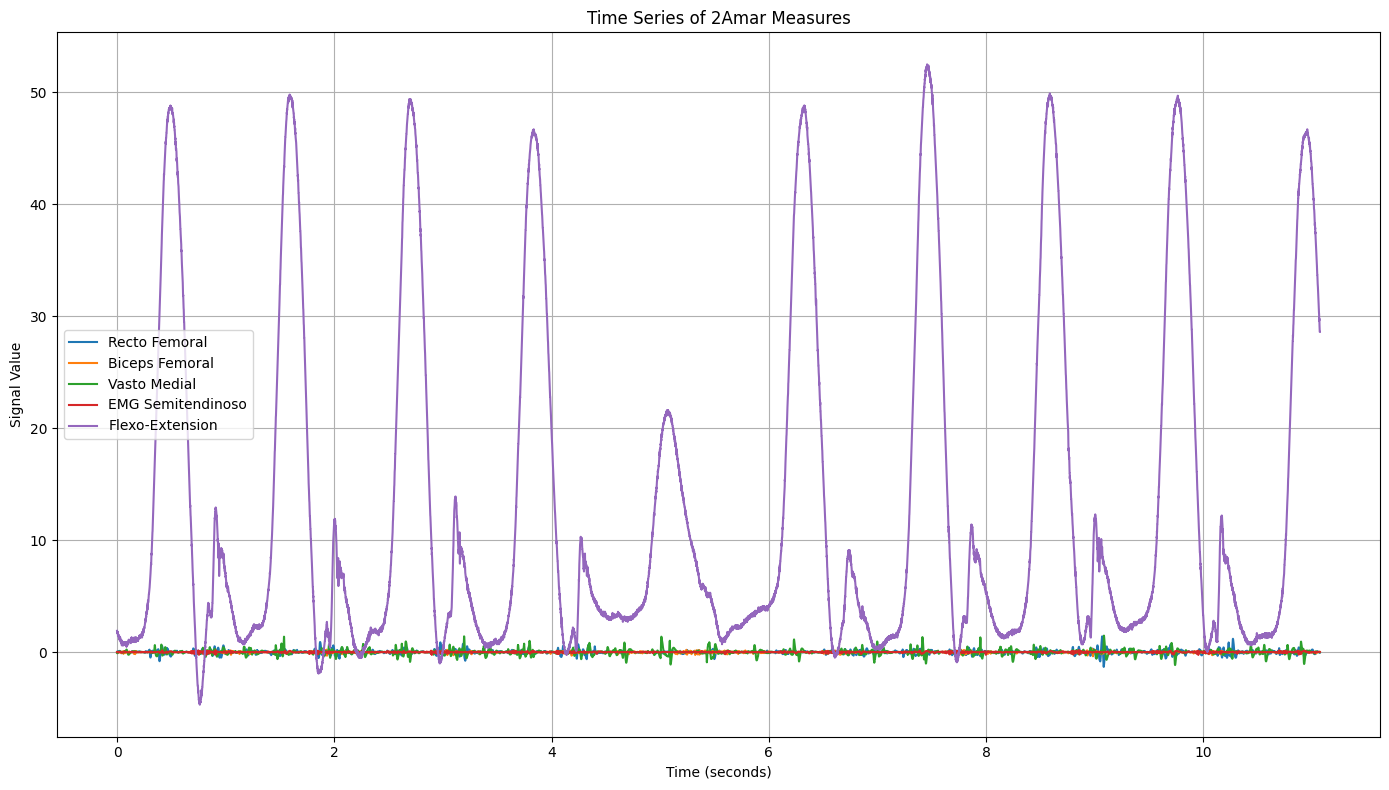

In [ ]:
import matplotlib.pyplot as plt

# Loading the DataFrame for 2Amar
df_2amar = dfs['2Amar'].copy()
df_2amar['Time (s)'] = df_2amar.index / 1000  # converts index to seconds

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso', 'Flexo-Extension']:
    plt.plot(df_2amar['Time (s)'], df_2amar[column], label=column)

plt.title("Time Series of 2Amar Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


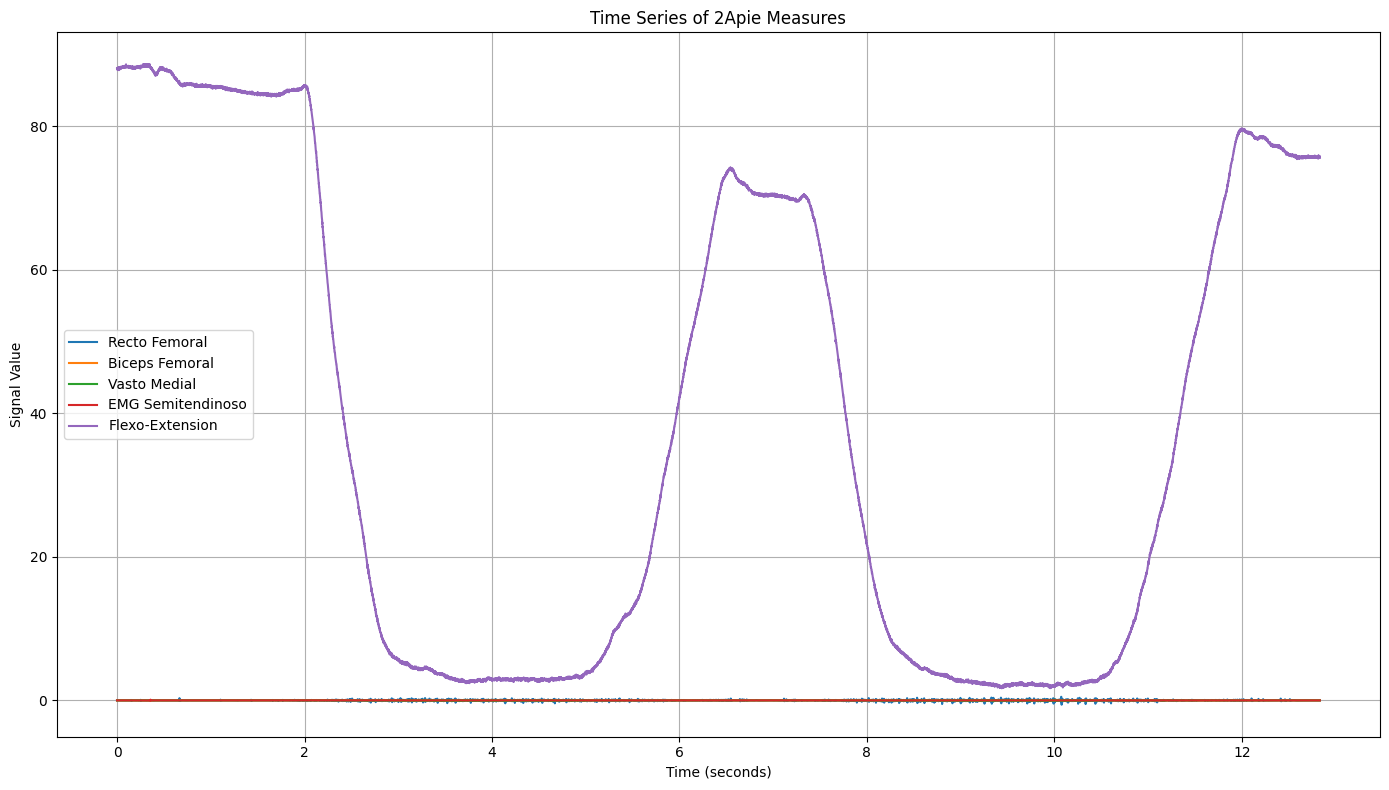

In [ ]:
# Loading the DataFrame for 2Apie
df_2apie = dfs['2Apie'].copy()

df_2apie['Time (s)'] = df_2apie.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso', 'Flexo-Extension']:
    plt.plot(df_2apie['Time (s)'], df_2apie[column], label=column)

plt.title("Time Series of 2Apie Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

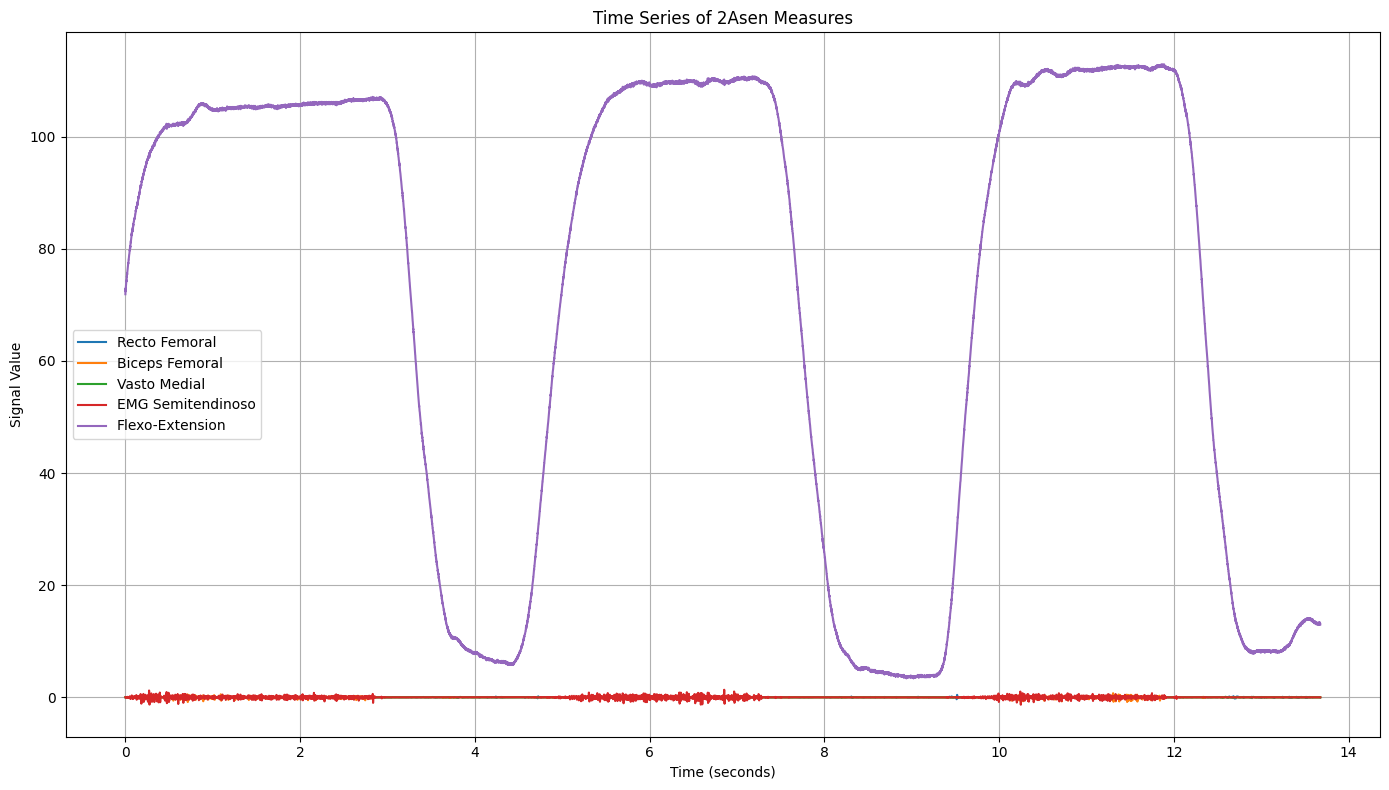

In [ ]:
# Loading the DataFrame for 2Asen
df_2asen = dfs['2Asen'].copy()

df_2asen['Time (s)'] = df_2asen.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso', 'Flexo-Extension']:
    plt.plot(df_2asen['Time (s)'], df_2asen[column], label=column)

plt.title("Time Series of 2Asen Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

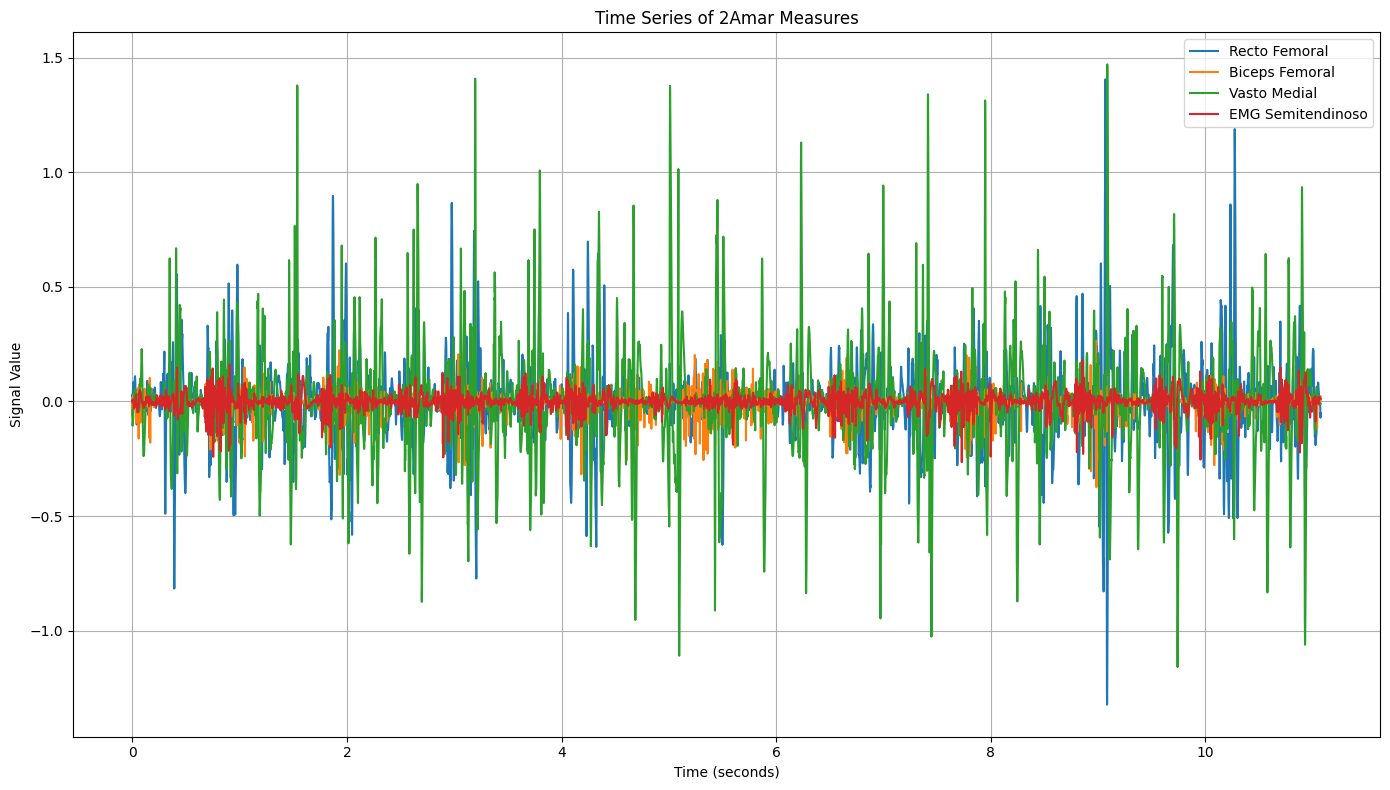

In [ ]:
# Loading the DataFrame for 2Amar
df_2amar = dfs['2Amar'].copy()  t

df_2amar['Time (s)'] = df_2amar.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']:
    plt.plot(df_2amar['Time (s)'], df_2amar[column], label=column)

plt.title("Time Series of 2Amar Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

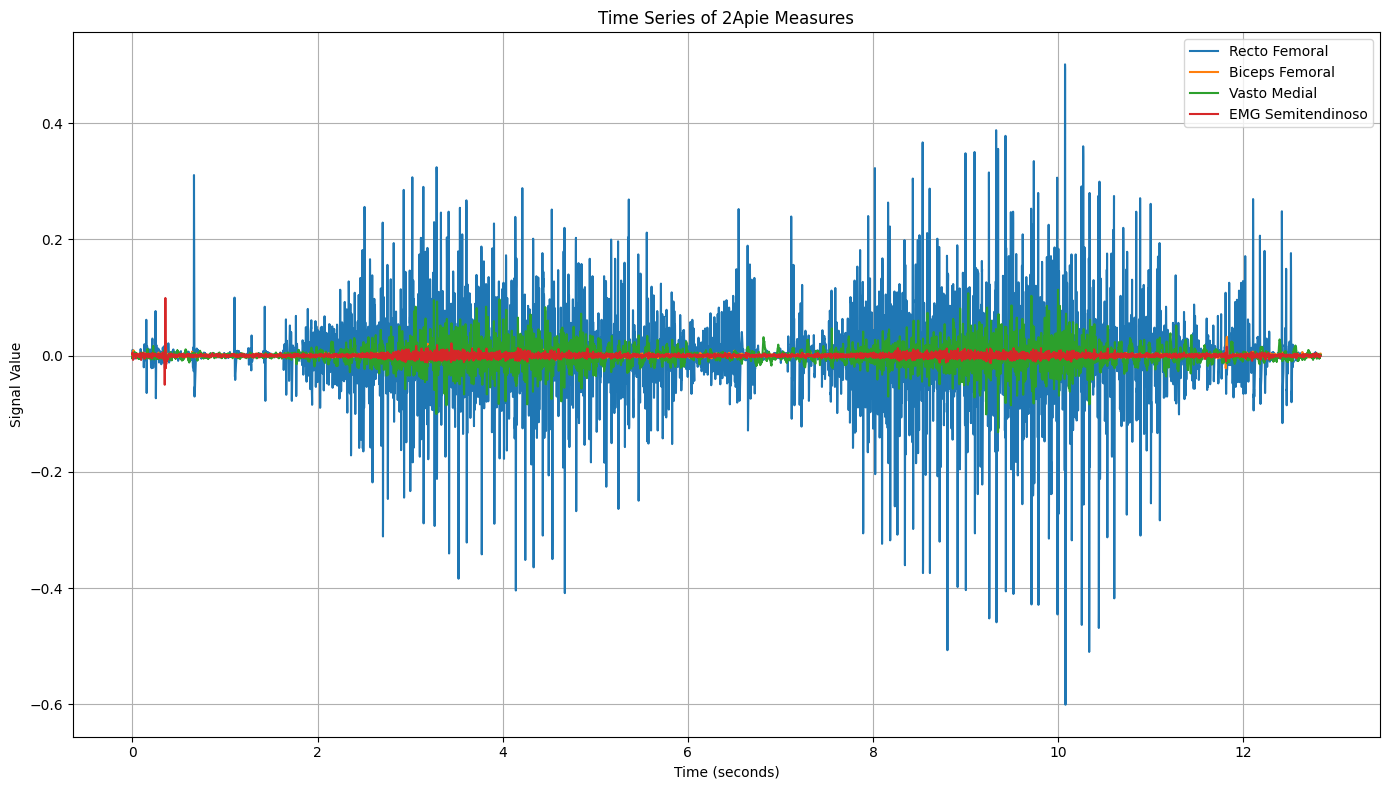

In [ ]:
# Loading the DataFrame for 2pie
df_2apie = dfs['2Apie'].copy()

df_2apie['Time (s)'] = df_2apie.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']:
    plt.plot(df_2apie['Time (s)'], df_2apie[column], label=column)

plt.title("Time Series of 2Apie Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

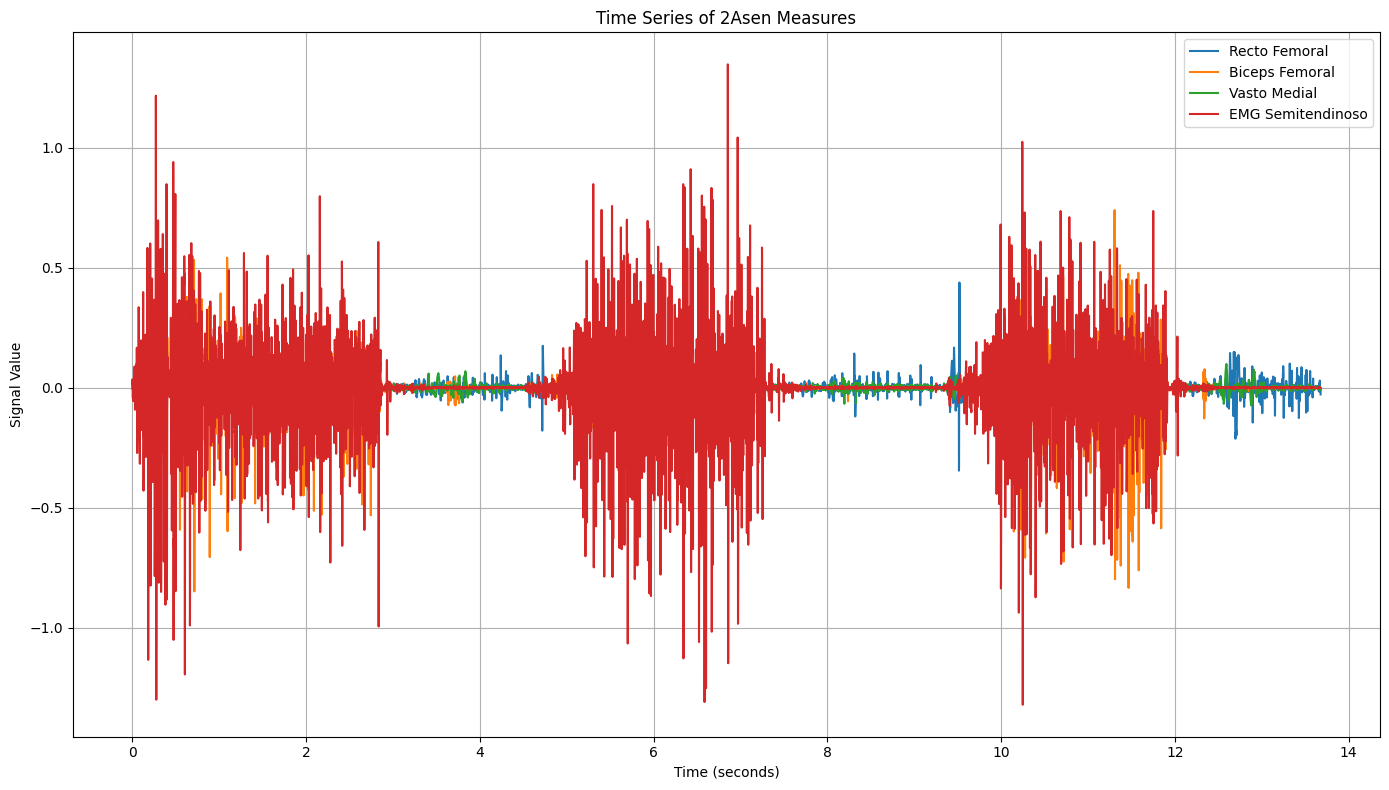

In [ ]:
# Loading the DataFrame for 2Asen
df_2asen = dfs['2Asen'].copy()

df_2asen['Time (s)'] = df_2asen.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']:
    plt.plot(df_2asen['Time (s)'], df_2asen[column], label=column)

plt.title("Time Series of 2Asen Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

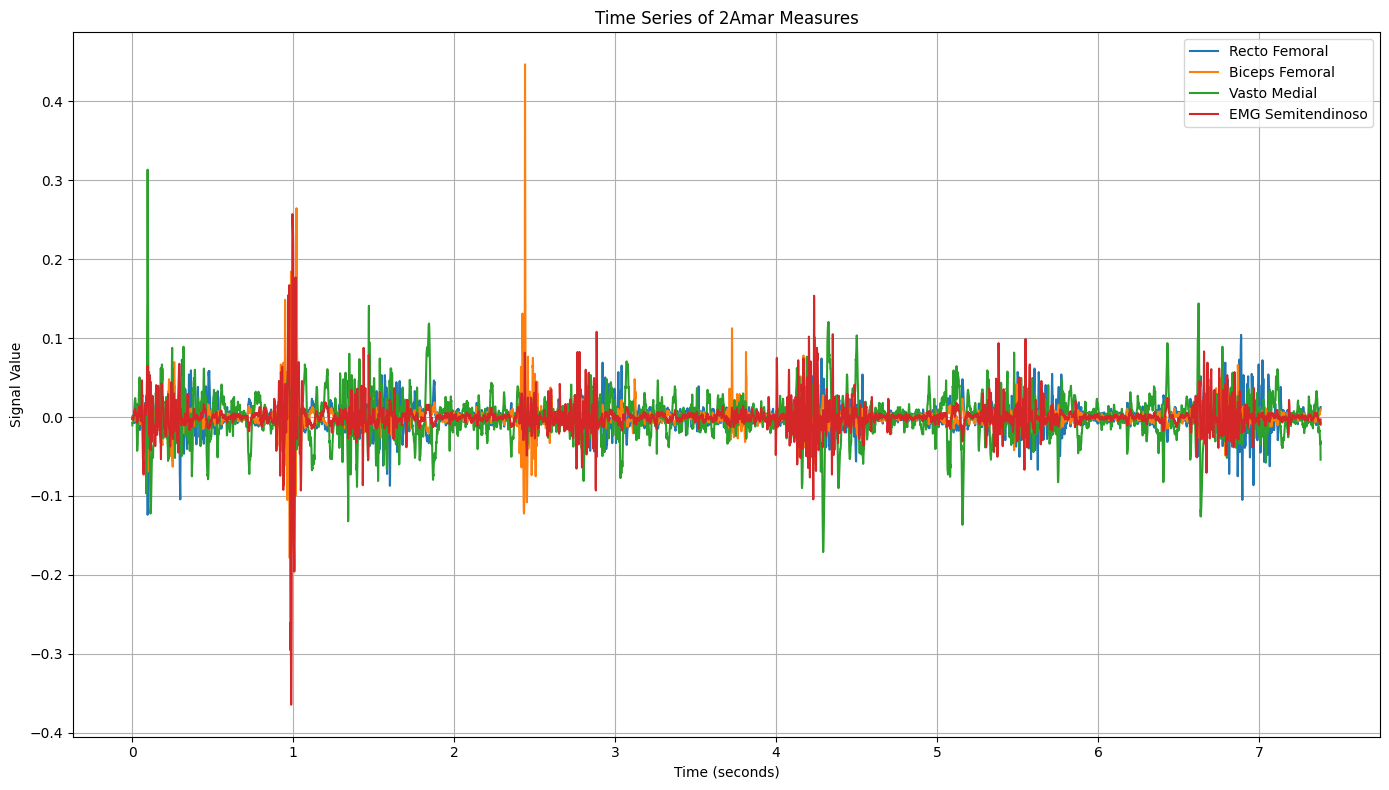

In [ ]:
# Loading the DataFrame for 2Nmar
df_2nmar = dfs['2Nmar'].copy()

df_2nmar['Time (s)'] = df_2nmar.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']:
    plt.plot(df_2nmar['Time (s)'], df_2nmar[column], label=column)

plt.title("Time Series of 2Nmar Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

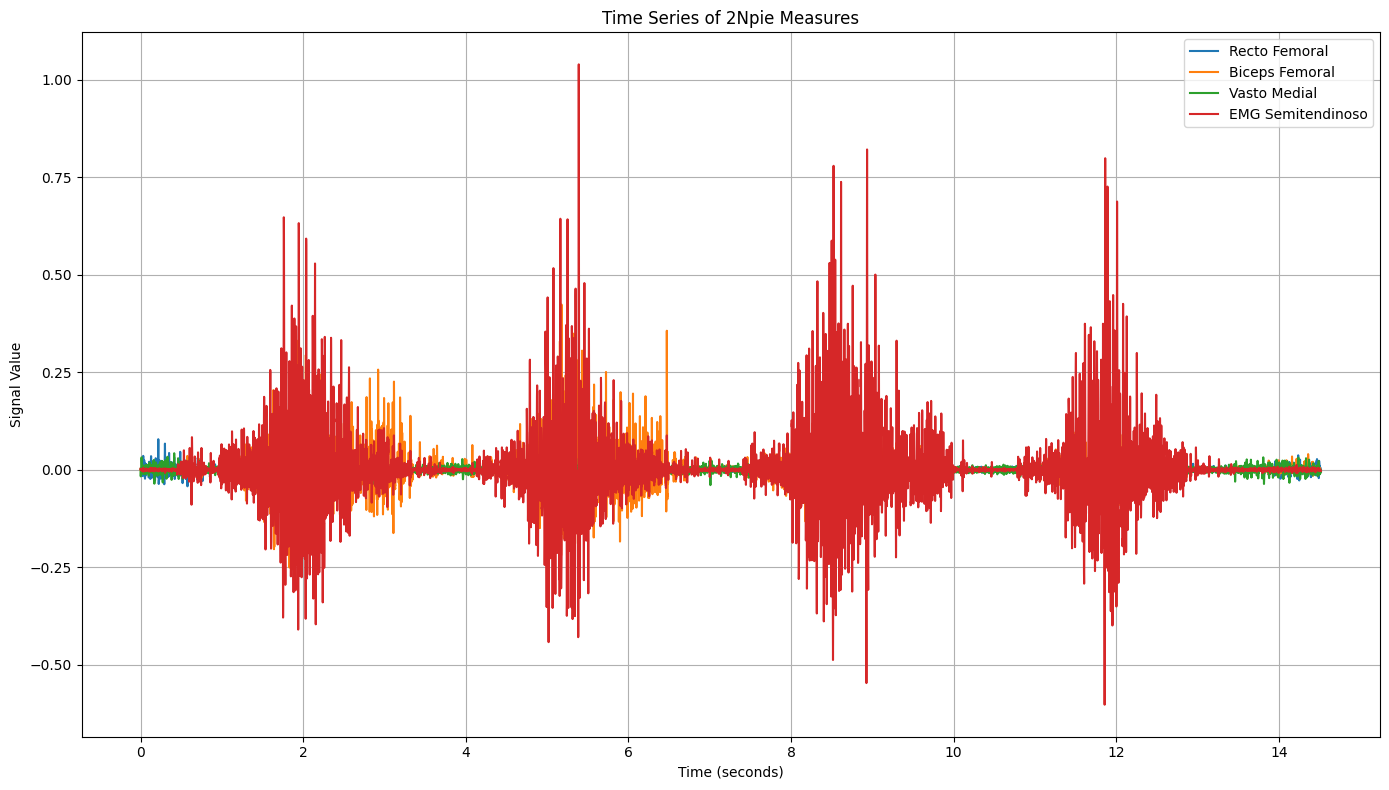

In [ ]:
# Loading the DataFrame for 2Npie
df_2npie = dfs['2Npie'].copy()

df_2npie['Time (s)'] = df_2npie.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']:
    plt.plot(df_2npie['Time (s)'], df_2npie[column], label=column)

plt.title("Time Series of 2Npie Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

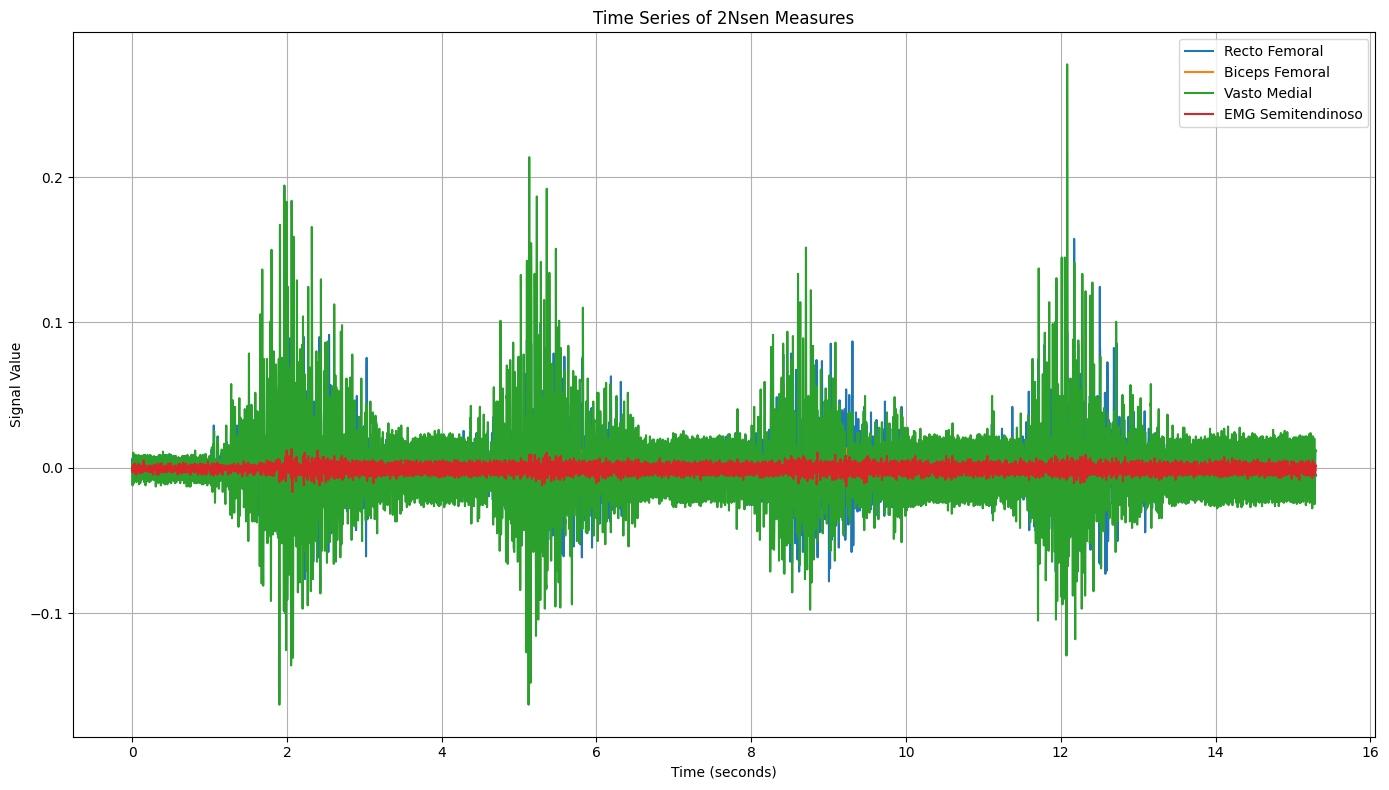

In [ ]:
# Loading the DataFrame for 2Nsen
df_2Nsen = dfs['2Nsen'].copy()

df_2Nsen['Time (s)'] = df_2Nsen.index / 1000

plt.figure(figsize=(14, 8))

for column in ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']:
    plt.plot(df_2Nsen['Time (s)'], df_2Nsen[column], label=column)

plt.title("Time Series of 2Nsen Measures")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
grouped = final_df.groupby(['Label', 'Exercise'])[
    ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso', 'Flexo-Extension']
].agg(['mean', 'std', 'max'])


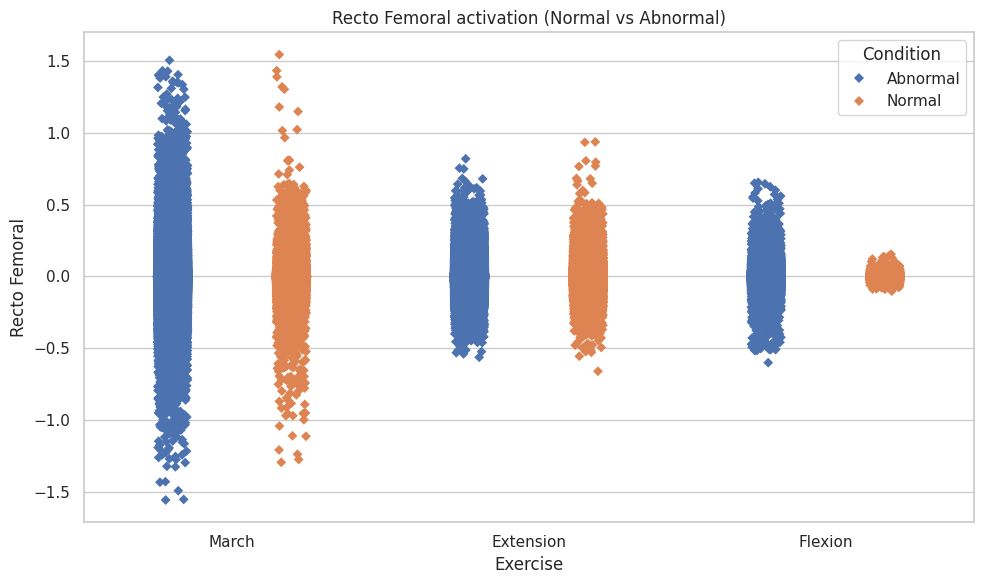

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=final_df, x='Exercise', y='Recto Femoral', hue='Label', dodge=True, jitter=True, marker='D')
plt.title("Recto Femoral activation (Normal vs Abnormal)")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()


<ipython-input-17-802105201dd6>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=final_df, x='Exercise', y='Recto Femoral', hue='Label', ci=None, marker='o')


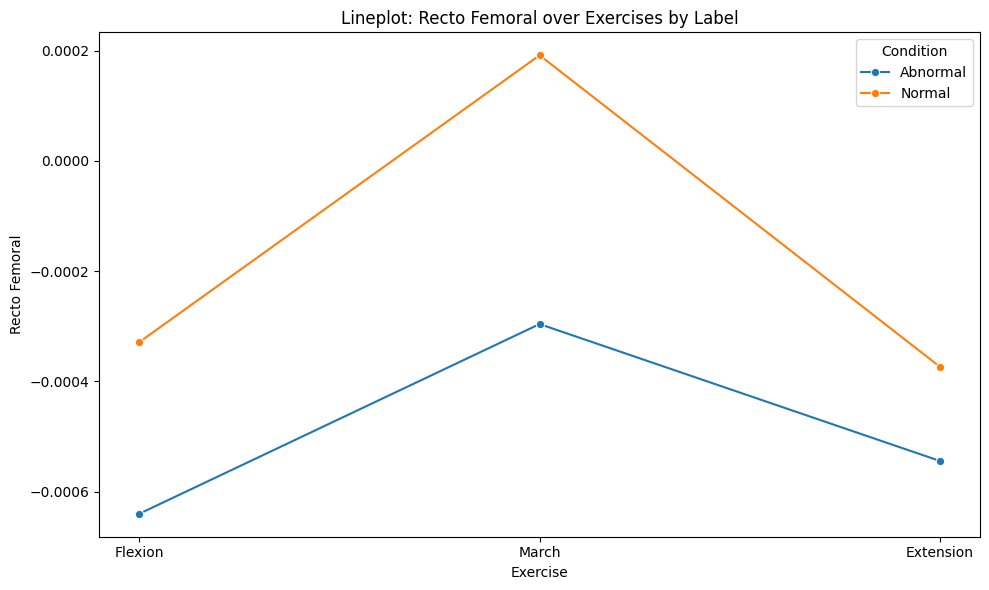

In [ ]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x='Exercise', y='Recto Femoral', hue='Label', ci=None, marker='o')
plt.title("Lineplot: Recto Femoral over Exercises by Label")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


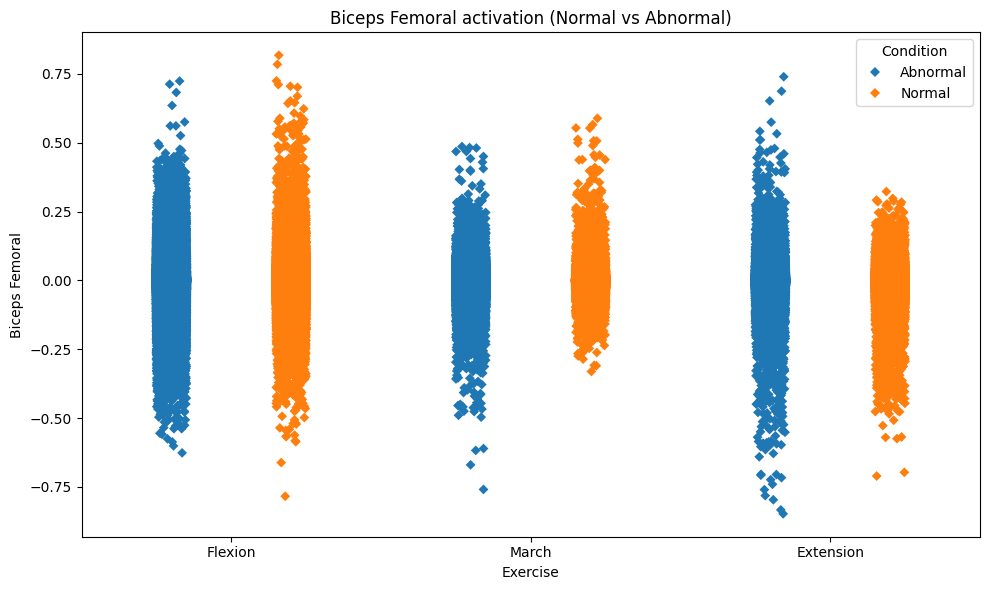

<ipython-input-18-bd3d01f5d187>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=final_df, x='Exercise', y='Biceps Femoral', hue='Label', ci=None, marker='o')


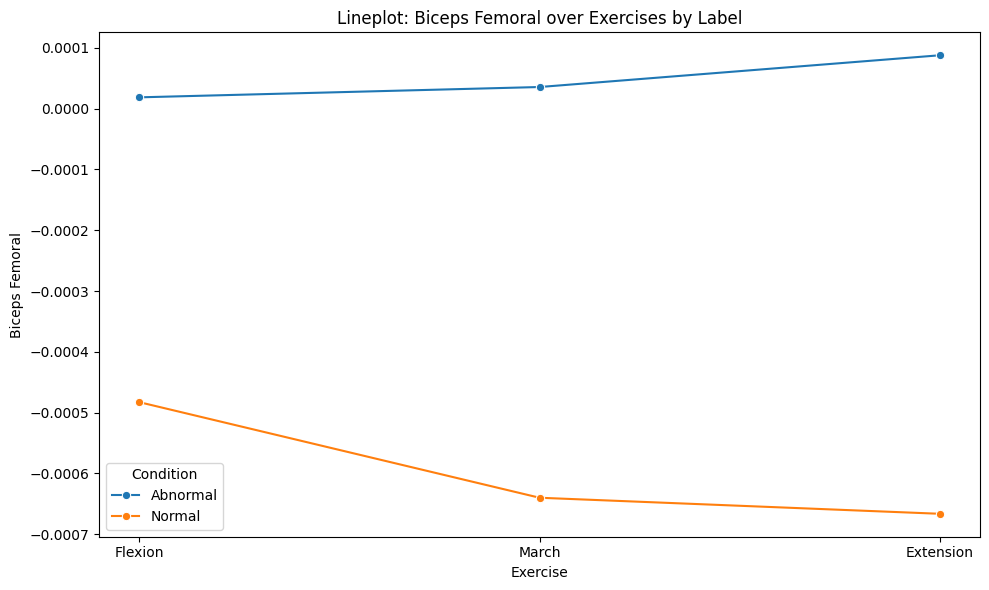

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=final_df, x='Exercise', y='Biceps Femoral', hue='Label', dodge=True, jitter=True, marker='D')
plt.title("Biceps Femoral activation (Normal vs Abnormal)")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x='Exercise', y='Biceps Femoral', hue='Label', ci=None, marker='o')
plt.title("Lineplot: Biceps Femoral over Exercises by Label")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

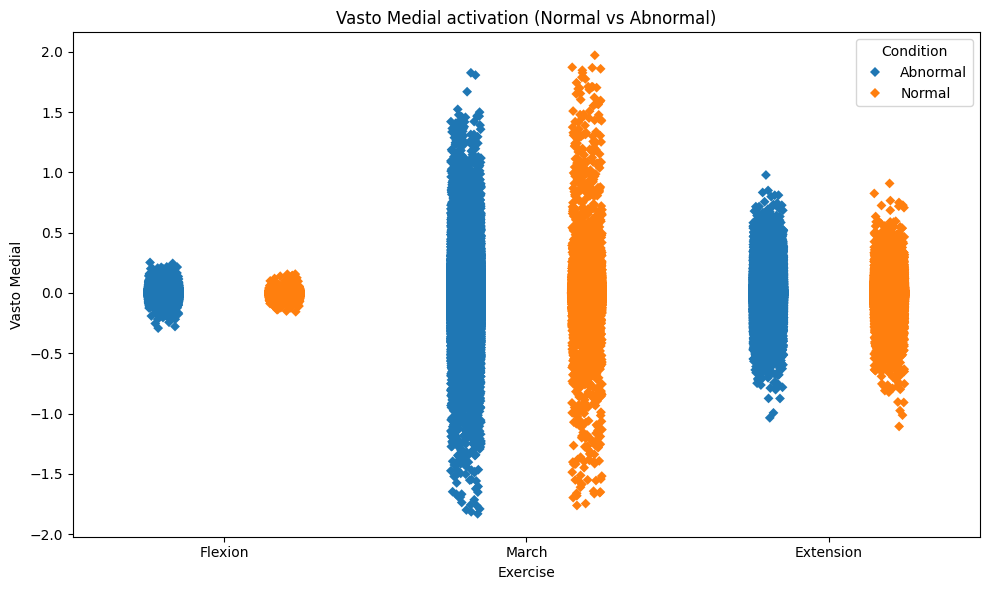

<ipython-input-19-381356fadca4>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=final_df, x='Exercise', y='Vasto Medial', hue='Label', ci=None, marker='o')


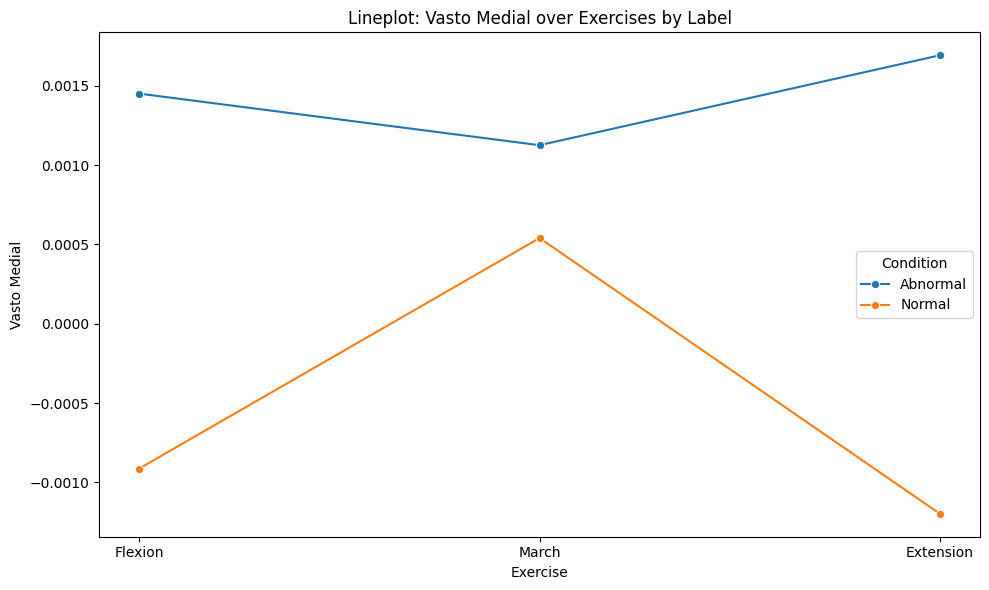

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=final_df, x='Exercise', y='Vasto Medial', hue='Label', dodge=True, jitter=True, marker='D')
plt.title("Vasto Medial activation (Normal vs Abnormal)")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x='Exercise', y='Vasto Medial', hue='Label', ci=None, marker='o')
plt.title("Lineplot: Vasto Medial over Exercises by Label")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

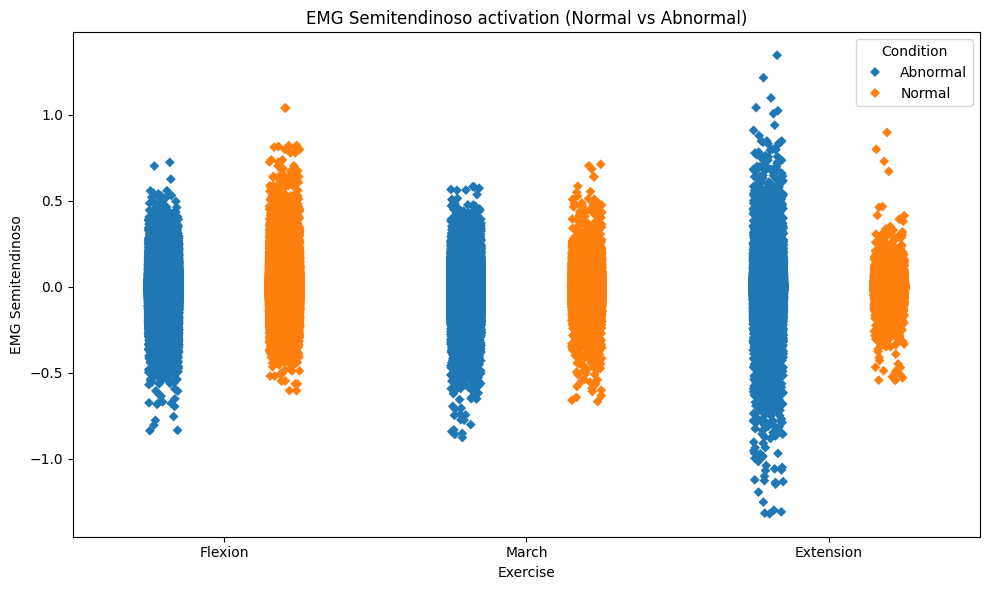

<ipython-input-20-01c6f7685682>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=final_df, x='Exercise', y='EMG Semitendinoso', hue='Label', ci=None, marker='o')


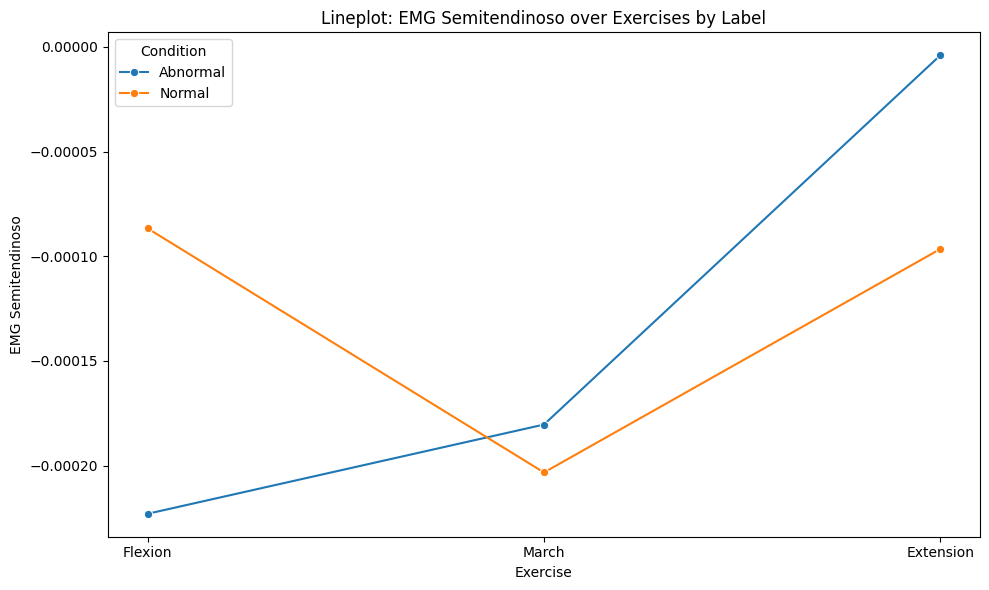

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=final_df, x='Exercise', y='EMG Semitendinoso', hue='Label', dodge=True, jitter=True, marker='D')
plt.title("EMG Semitendinoso activation (Normal vs Abnormal)")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x='Exercise', y='EMG Semitendinoso', hue='Label', ci=None, marker='o')
plt.title("Lineplot: EMG Semitendinoso over Exercises by Label")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

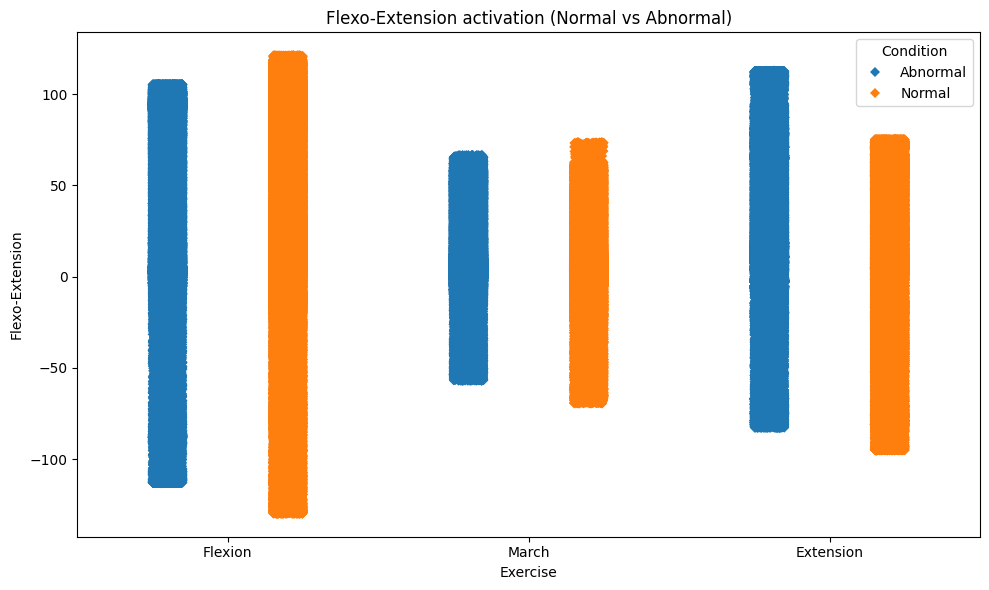

<ipython-input-21-4f8e7a8677e2>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=final_df, x='Exercise', y='Flexo-Extension', hue='Label', ci=None, marker='o')


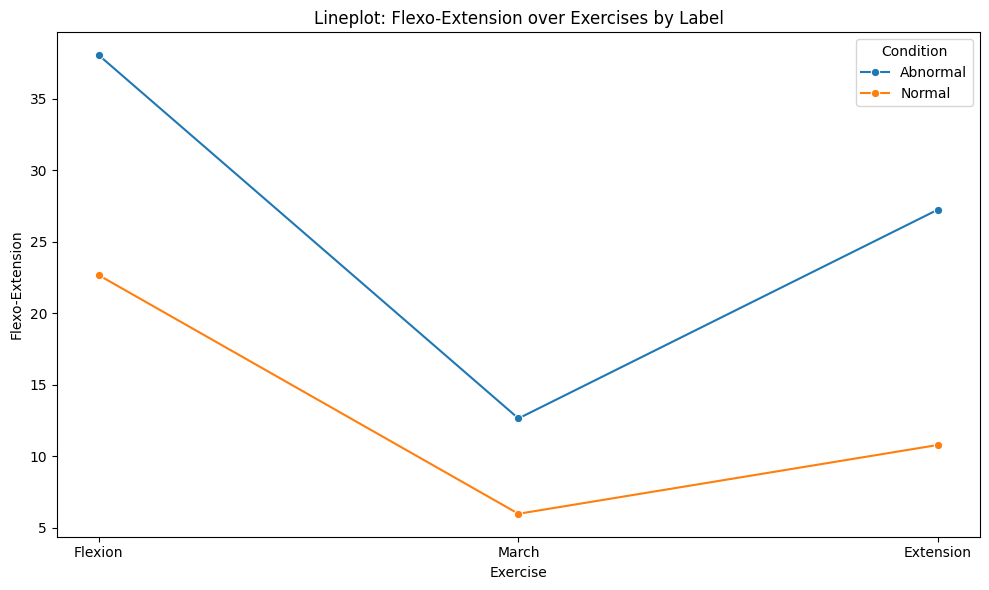

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=final_df, x='Exercise', y='Flexo-Extension', hue='Label', dodge=True, jitter=True, marker='D')
plt.title("Flexo-Extension activation (Normal vs Abnormal)")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_df, x='Exercise', y='Flexo-Extension', hue='Label', ci=None, marker='o')
plt.title("Lineplot: Flexo-Extension over Exercises by Label")
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

<ipython-input-22-785eee014788>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='Exercise', y='Activation', hue='Label', style='Muscle', markers=True, ci=None)


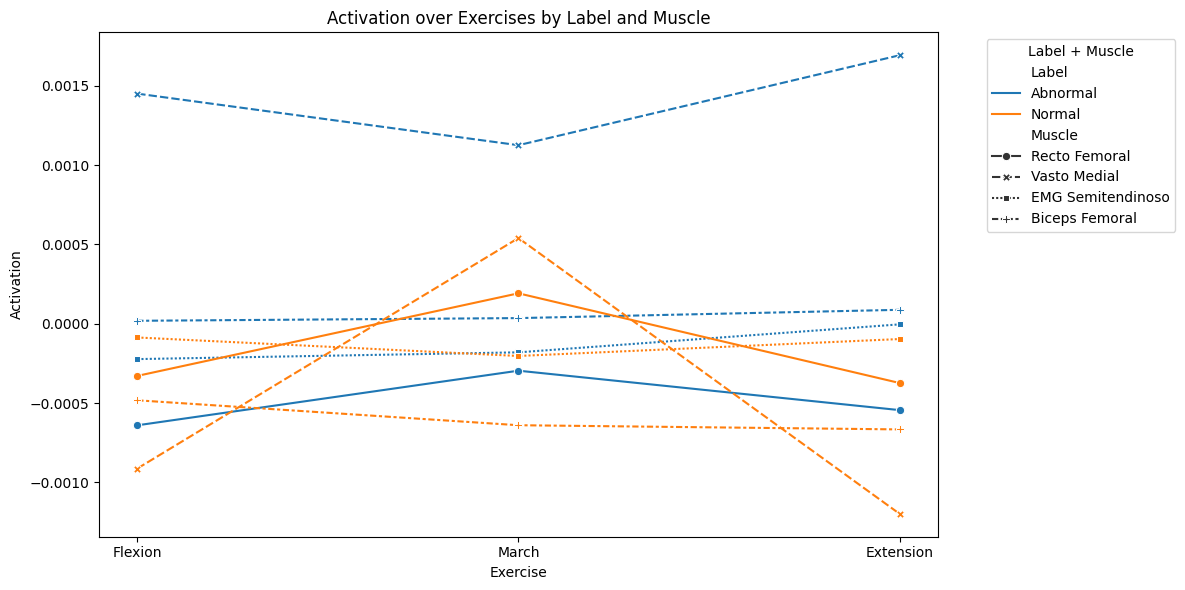

In [ ]:
# Melting the DataFrame to long format
melted_df = final_df.melt(
    id_vars=['Exercise', 'Label'],
    value_vars=['Recto Femoral', 'Vasto Medial', 'EMG Semitendinoso', 'Biceps Femoral'],
    var_name='Muscle',
    value_name='Activation'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Exercise', y='Activation', hue='Label', style='Muscle', markers=True, ci=None)
plt.title("Activation over Exercises by Label and Muscle")
plt.legend(title='Label + Muscle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:

summary_stats = (
    melted_df
    .groupby(['Muscle', 'Exercise', 'Label'])
    .agg(
        Mean_Activation=('Activation', 'mean'),
        Std_Deviation=('Activation', 'std'),
        Count=('Activation', 'count')
    )
    .reset_index()
)

print(summary_stats)


               Muscle   Exercise     Label  Mean_Activation  Std_Deviation  \
0      Biceps Femoral  Extension  Abnormal         0.000088       0.025773   
1      Biceps Femoral  Extension    Normal        -0.000666       0.021191   
2      Biceps Femoral    Flexion  Abnormal         0.000018       0.059917   
3      Biceps Femoral    Flexion    Normal        -0.000483       0.043574   
4      Biceps Femoral      March  Abnormal         0.000035       0.025932   
5      Biceps Femoral      March    Normal        -0.000640       0.025318   
6   EMG Semitendinoso  Extension  Abnormal        -0.000004       0.045727   
7   EMG Semitendinoso  Extension    Normal        -0.000097       0.014770   
8   EMG Semitendinoso    Flexion  Abnormal        -0.000223       0.059492   
9   EMG Semitendinoso    Flexion    Normal        -0.000087       0.053475   
10  EMG Semitendinoso      March  Abnormal        -0.000180       0.050297   
11  EMG Semitendinoso      March    Normal        -0.000203     

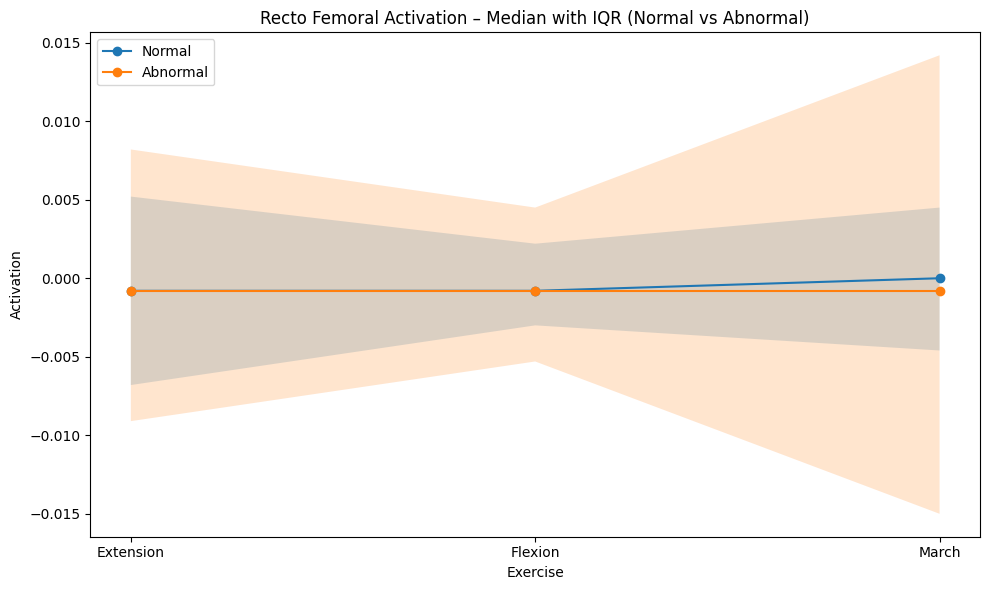

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melting the DataFrame for tidy format
melted_df = final_df.melt(
    id_vars=['Exercise', 'Label'],
    value_vars=['Recto Femoral'],
    var_name='Muscle',
    value_name='Activation'
)

# Calculate Q1, median, Q3
iqr_summary = (
    melted_df.groupby(['Exercise', 'Label'])['Activation']
    .quantile([0.25, 0.5, 0.75])
    .unstack()
    .reset_index()
    .rename(columns={0.25: 'Q1', 0.5: 'Median', 0.75: 'Q3'})
)

plt.figure(figsize=(10, 6))

for label in ['Normal', 'Abnormal']:
    subset = iqr_summary[iqr_summary['Label'] == label]
    plt.plot(subset['Exercise'], subset['Median'], label=f"{label}", marker='o')
    plt.fill_between(subset['Exercise'], subset['Q1'], subset['Q3'], alpha=0.2)

plt.title("Recto Femoral Activation – Median with IQR (Normal vs Abnormal)")
plt.xlabel("Exercise")
plt.ylabel("Activation")
plt.legend()
plt.tight_layout()
plt.show()


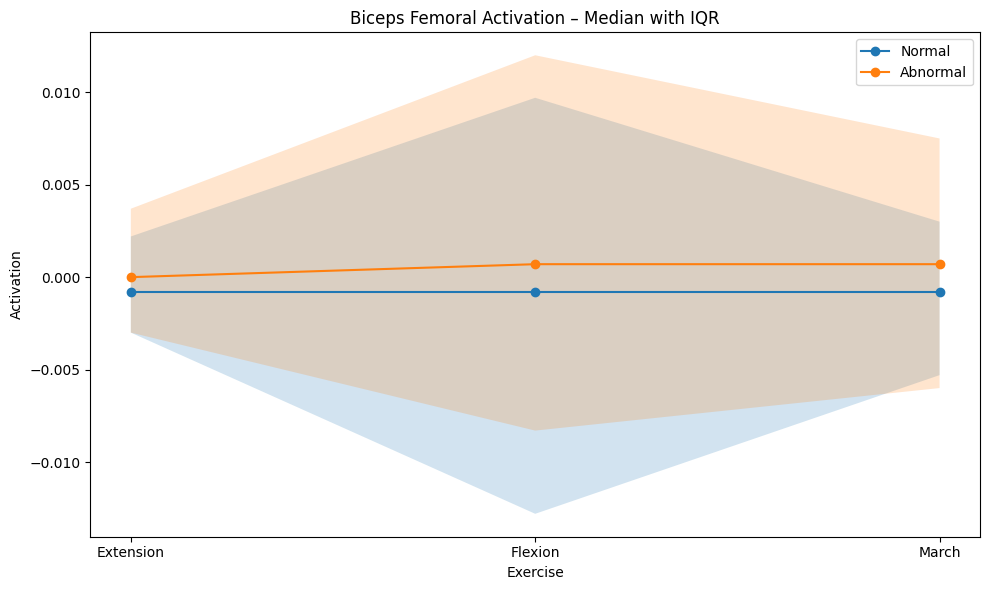

In [ ]:

melted_bf = final_df.melt(id_vars=['Exercise', 'Label'], value_vars=['Biceps Femoral'],
                          var_name='Muscle', value_name='Activation')

iqr_bf = (
    melted_bf.groupby(['Exercise', 'Label'])['Activation']
    .quantile([0.25, 0.5, 0.75])
    .unstack()
    .reset_index()
    .rename(columns={0.25: 'Q1', 0.5: 'Median', 0.75: 'Q3'})
)

plt.figure(figsize=(10, 6))
for label in ['Normal', 'Abnormal']:
    subset = iqr_bf[iqr_bf['Label'] == label]
    plt.plot(subset['Exercise'], subset['Median'], label=label, marker='o')
    plt.fill_between(subset['Exercise'], subset['Q1'], subset['Q3'], alpha=0.2)
plt.title("Biceps Femoral Activation – Median with IQR")
plt.xlabel("Exercise")
plt.ylabel("Activation")
plt.legend()
plt.tight_layout()
plt.show()


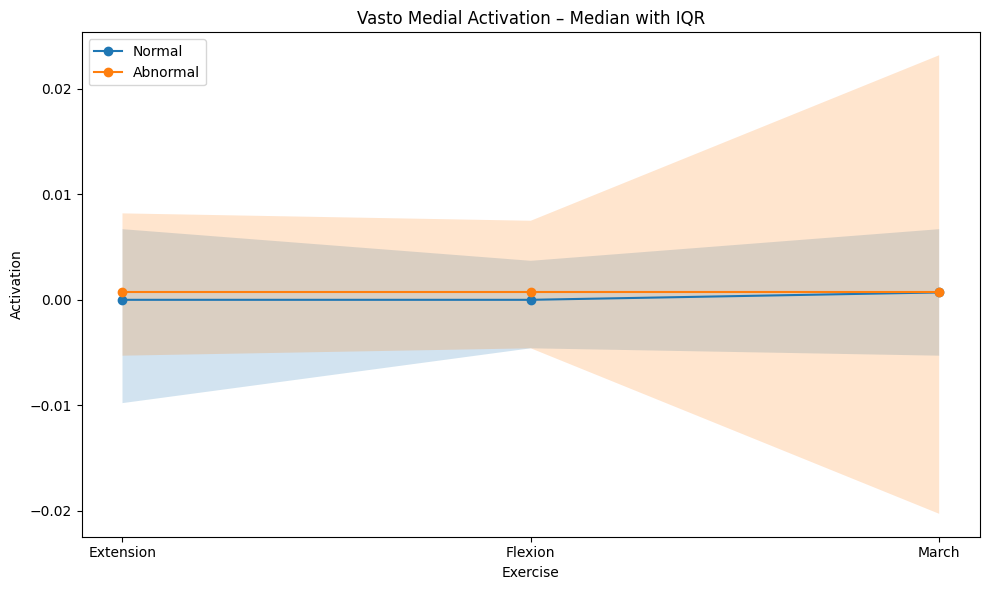

In [ ]:

melted_vm = final_df.melt(id_vars=['Exercise', 'Label'], value_vars=['Vasto Medial'],
                          var_name='Muscle', value_name='Activation')

iqr_vm = (
    melted_vm.groupby(['Exercise', 'Label'])['Activation']
    .quantile([0.25, 0.5, 0.75])
    .unstack()
    .reset_index()
    .rename(columns={0.25: 'Q1', 0.5: 'Median', 0.75: 'Q3'})
)

plt.figure(figsize=(10, 6))
for label in ['Normal', 'Abnormal']:
    subset = iqr_vm[iqr_vm['Label'] == label]
    plt.plot(subset['Exercise'], subset['Median'], label=label, marker='o')
    plt.fill_between(subset['Exercise'], subset['Q1'], subset['Q3'], alpha=0.2)
plt.title("Vasto Medial Activation – Median with IQR")
plt.xlabel("Exercise")
plt.ylabel("Activation")
plt.legend()
plt.tight_layout()
plt.show()


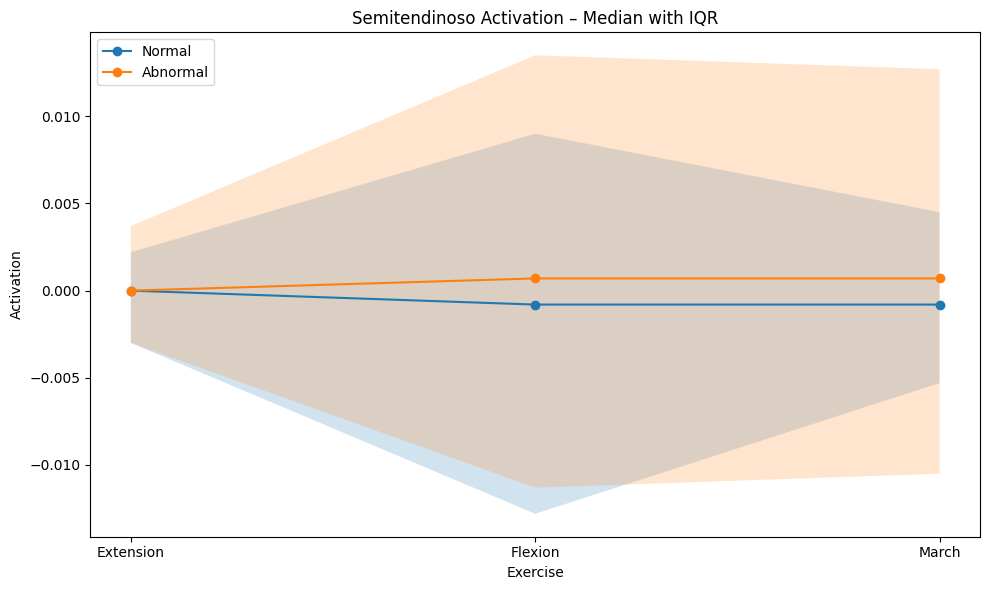

In [ ]:

melted_st = final_df.melt(id_vars=['Exercise', 'Label'], value_vars=['EMG Semitendinoso'],
                          var_name='Muscle', value_name='Activation')

iqr_st = (
    melted_st.groupby(['Exercise', 'Label'])['Activation']
    .quantile([0.25, 0.5, 0.75])
    .unstack()
    .reset_index()
    .rename(columns={0.25: 'Q1', 0.5: 'Median', 0.75: 'Q3'})
)

plt.figure(figsize=(10, 6))
for label in ['Normal', 'Abnormal']:
    subset = iqr_st[iqr_st['Label'] == label]
    plt.plot(subset['Exercise'], subset['Median'], label=label, marker='o')
    plt.fill_between(subset['Exercise'], subset['Q1'], subset['Q3'], alpha=0.2)
plt.title("Semitendinoso Activation – Median with IQR")
plt.xlabel("Exercise")
plt.ylabel("Activation")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
final_df[['Subject', 'Exercise']].drop_duplicates().value_counts()


Subject  Exercise 
1        Extension    1
         Flexion      1
         March        1
2        Extension    1
         Flexion      1
         March        1
3        Extension    1
         Flexion      1
         March        1
4        Extension    1
         Flexion      1
         March        1
5        Extension    1
         Flexion      1
         March        1
6        Extension    1
         Flexion      1
         March        1
7        Extension    1
         Flexion      1
         March        1
8        Extension    1
         Flexion      1
         March        1
9        Extension    1
         Flexion      1
         March        1
10       Extension    1
         Flexion      1
         March        1
11       Extension    1
         Flexion      1
         March        1
Name: count, dtype: int64

In [ ]:
# Grouping by Subject, Exercise & Label
grouped_df = final_df.groupby(['Subject', 'Exercise', 'Label']).agg({
    'Recto Femoral': 'mean',
    'Biceps Femoral': 'mean',
    'Vasto Medial': 'mean',
    'EMG Semitendinoso': 'mean',
    'Flexo-Extension': 'mean'
}).reset_index()

pd.set_option('display.max_rows', None)

display(grouped_df)


,Subject,Exercise,Label,Recto Femoral,Biceps Femoral,Vasto Medial,EMG Semitendinoso,Flexo-Extension
0,1,Extension,Abnormal,-0.000168,-0.000626,-0.000649,0.000712,-29.402433
1,1,Extension,Normal,0.000381,-0.000319,-0.000072,-0.000407,51.337529
2,1,Flexion,Abnormal,-0.000336,-0.000661,-0.000474,0.000591,-58.798693
3,1,Flexion,Normal,0.000333,-0.000272,-0.000132,-0.000365,53.492280
4,1,March,Abnormal,-0.000139,-0.000626,-0.000609,0.000687,-12.796870
5,1,March,Normal,0.000424,-0.000293,-0.000102,-0.000392,19.360148
6,2,Extension,Abnormal,-0.000170,-0.000129,-0.000514,-0.000180,72.883110
7,2,Extension,Normal,0.000381,-0.000319,-0.000072,-0.000407,51.337529
8,2,Flexion,Abnormal,0.000053,-0.000115,-0.000598,-0.000100,37.619378
9,2,Flexion,Normal,0.000333,-0.000272,-0.000132,-0.000365,53.492280


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Filtering to 'Extension' exercises
standing_df = grouped_df[grouped_df['Exercise'] == 'Extension']

# Selecting features and target
features = ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']
X = standing_df[features]
y = standing_df['Label'].map({'Normal': 0, 'Abnormal': 1})

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Training model
model = LogisticRegression()
model.fit(X_scaled, y)

# Evaluation
y_pred = model.predict(X_scaled)
print(classification_report(y, y_pred))

# Simulate a new subject based on the distribution (e.g., using normal distribution from real data)
random_subject = pd.DataFrame({
    col: [np.random.normal(loc=X[col].mean(), scale=X[col].std())]
    for col in features
})

# Standardizing the new data
random_subject_scaled = scaler.transform(random_subject)

# Prediction
prediction = model.predict(random_subject_scaled)
print("Prediction for simulated subject:", "Normal" if prediction[0] == 0 else "Abnormal")

# Show the simulated values
print("\nSimulated EMG values:\n", random_subject)



              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19

Prediction for simulated subject: Normal

Simulated EMG values:
    Recto Femoral  Biceps Femoral  Vasto Medial  EMG Semitendinoso
0      -0.000279       -0.000602     -0.003848          -0.001175


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Filter to 'March' exercises
standing_df = grouped_df[grouped_df['Exercise'] == 'March']

# Select features and target
features = ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']
X = standing_df[features]
y = standing_df['Label'].map({'Normal': 0, 'Abnormal': 1})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = LogisticRegression()
model.fit(X_scaled, y)

# Evaluate
y_pred = model.predict(X_scaled)
print(classification_report(y, y_pred))

# Simulate a new subject based on the distribution (e.g., using normal distribution from real data)
random_subject = pd.DataFrame({
    col: [np.random.normal(loc=X[col].mean(), scale=X[col].std())]
    for col in features
})

# Standardize the new data
random_subject_scaled = scaler.transform(random_subject)

# Predict
prediction = model.predict(random_subject_scaled)
print("Prediction for simulated subject:", "Normal" if prediction[0] == 0 else "Abnormal")

# Show the simulated values
print("\nSimulated EMG values:\n", random_subject)

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19

Prediction for simulated subject: Normal

Simulated EMG values:
    Recto Femoral  Biceps Femoral  Vasto Medial  EMG Semitendinoso
0       0.002274       -0.000216      0.001814           0.000328


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Filter to 'Flexion' exercises
standing_df = grouped_df[grouped_df['Exercise'] == 'Flexion']

# Select features and target
features = ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']
X = standing_df[features]
y = standing_df['Label'].map({'Normal': 0, 'Abnormal': 1})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = LogisticRegression()
model.fit(X_scaled, y)

# Evaluate
y_pred = model.predict(X_scaled)
print(classification_report(y, y_pred))

# Simulate a new subject based on the distribution (e.g., using normal distribution from real data)
random_subject = pd.DataFrame({
    col: [np.random.normal(loc=X[col].mean(), scale=X[col].std())]
    for col in features
})

# Standardize the new data
random_subject_scaled = scaler.transform(random_subject)

# Predict
prediction = model.predict(random_subject_scaled)
print("Prediction for simulated subject:", "Normal" if prediction[0] == 0 else "Abnormal")

# Show the simulated values
print("\nSimulated EMG values:\n", random_subject)

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.71      0.62      0.67         8

    accuracy                           0.74        19
   macro avg       0.73      0.72      0.72        19
weighted avg       0.73      0.74      0.73        19

Prediction for simulated subject: Normal

Simulated EMG values:
    Recto Femoral  Biceps Femoral  Vasto Medial  EMG Semitendinoso
0       0.001727       -0.000573       -0.0004            0.00034


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter

exercises = ['Extension', 'Flexion', 'March']
features = ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']

models = {}
scalers = {}
predictions = []
simulated_subjects = {}

y_true_all = []
y_pred_all = []

for exercise in exercises:
    df = grouped_df[grouped_df['Exercise'] == exercise]
    if df.empty:
        continue

    X = df[features]
    y = df['Label'].map({'Normal': 0, 'Abnormal': 1})

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression()
    model.fit(X_scaled, y)

    y_pred = model.predict(X_scaled)
    y_true_all.extend(y)
    y_pred_all.extend(y_pred)

    print(f"\n=== {exercise} ===")
    print(classification_report(y, y_pred))

    simulated_subject = pd.DataFrame({
        col: [np.random.normal(loc=X[col].mean(), scale=X[col].std())] for col in features
    })
    simulated_subjects[exercise] = simulated_subject

    simulated_scaled = scaler.transform(simulated_subject)
    pred = model.predict(simulated_scaled)[0]
    predictions.append(pred)
    print(f"Prediction: {'Normal' if pred == 0 else 'Abnormal'}")

    models[exercise] = model
    scalers[exercise] = scaler

final_prediction = Counter(predictions).most_common(1)[0][0]
print("\n=== FINAL VOTING RESULT ===")
print("Final prediction:", "Normal" if final_prediction == 0 else "Abnormal")

print("\n=== Simulated EMG values per exercise ===")
for exercise, subject_data in simulated_subjects.items():
    print(f"\n{exercise}:\n{subject_data}")

print("\n=== COMBINED METRICS ACROSS ALL EXERCISES ===")
print(classification_report(y_true_all, y_pred_all))



=== Extension ===
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19

Prediction: Normal

=== Flexion ===
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.71      0.62      0.67         8

    accuracy                           0.74        19
   macro avg       0.73      0.72      0.72        19
weighted avg       0.73      0.74      0.73        19

Prediction: Normal

=== March ===
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from collections import Counter

# Define exercises to include
exercises = ['Extension', 'Flexion', 'March']

# Define features
features = ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']

# Storage for models, scalers, and predictions
models = {}
scalers = {}
predictions = []
simulated_subjects = {}

# Train and evaluate models for each exercise
for exercise in exercises:
    df = grouped_df[grouped_df['Exercise'] == exercise]

    if df.empty:
        print(f"Skipping {exercise}: No data available.")
        continue

    X = df[features]
    y = df['Label'].map({'Normal': 0, 'Abnormal': 1})

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define classifiers
    models[exercise] = {
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier()
    }

    # Evaluate each classifier
    print(f"\n=== {exercise} ===")
    for model_name, model in models[exercise].items():
        # Train model
        model.fit(X_scaled, y)

        # Predict and evaluate
        y_pred = model.predict(X_scaled)
        print(f"\n{model_name} Report:")
        print(classification_report(y, y_pred))

        # Store the predictions and model
        predictions.append(y_pred)

    # Create a Voting Classifier
    voting_clf = VotingClassifier(estimators=[
        ('logreg', LogisticRegression()),
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('rf', RandomForestClassifier())
    ], voting='hard')

    # Train Voting Classifier
    voting_clf.fit(X_scaled, y)

    # Predict and evaluate Voting Classifier
    y_pred_voting = voting_clf.predict(X_scaled)
    print(f"\nVoting Classifier Report:")
    print(classification_report(y, y_pred_voting))

    # Simulate a subject from this exercise
    simulated_subject = pd.DataFrame({
        col: [np.random.normal(loc=X[col].mean(), scale=X[col].std())] for col in features
    })
    simulated_subjects[exercise] = simulated_subject  # Store for later viewing

    # Standardize and predict
    simulated_scaled = scaler.transform(simulated_subject)
    pred = voting_clf.predict(simulated_scaled)[0]
    print(f"Prediction for simulated subject using Voting Classifier: {'Normal' if pred == 0 else 'Abnormal'}")

    # Save model and scaler
    scalers[exercise] = scaler

# Final voting from all models (SVM, KNN, Random Forest, Voting Classifier)
final_predictions = []
for i in range(len(predictions[0])):  # Iterate through each data point
    # Get the predictions for each model
    model_preds = [pred[i] for pred in predictions]

    # Get the final prediction by majority vote
    final_prediction = Counter(model_preds).most_common(1)[0][0]
    final_predictions.append(final_prediction)

# Print the final combined metrics for Voting Classifier
print("\n=== FINAL COMBINED METRICS ACROSS ALL EXERCISES ===")
print(classification_report(y, final_predictions))

# Show simulated values per exercise
print("\n=== Simulated EMG values per exercise ===")
for exercise, subject_data in simulated_subjects.items():
    print(f"\n{exercise}:\n{subject_data}")



=== Extension ===

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19


SVM Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19


KNN Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report
from collections import Counter

# Define exercises and features
exercises = ['Extension', 'Flexion', 'March']
features = ['Recto Femoral', 'Biceps Femoral', 'Vasto Medial', 'EMG Semitendinoso']

# Storage
models = {}
scalers = {}
predictions = []
simulated_subjects = {}

# Loop through each exercise
for exercise in exercises:
    df = grouped_df[grouped_df['Exercise'] == exercise]

    if df.empty:
        print(f"Skipping {exercise}: No data available.")
        continue

    X = df[features]
    y = df['Label'].map({'Normal': 0, 'Abnormal': 1})

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define base models
    base_models = [
        ('logreg', LogisticRegression()),
        ('knn', KNeighborsClassifier()),
        ('rf', RandomForestClassifier())
    ]

    # Define stacking classifier with logistic regression as meta-model
    stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

    # Store the models for reference
    models[exercise] = {
        'Stacking': stacking_clf,
        'Logistic Regression': base_models[0][1],
        'KNN': base_models[1][1],
        'Random Forest': base_models[2][1]
    }

    print(f"\n=== {exercise} ===")

    # Train and evaluate each individual model
    for name, model in models[exercise].items():
        model.fit(X_scaled, y)
        y_pred = model.predict(X_scaled)
        print(f"\n{name} Report:")
        print(classification_report(y, y_pred))
        if name != 'Stacking':
            predictions.append(y_pred)

    # Simulate subject EMG data
    simulated_subject = pd.DataFrame({
        col: [np.random.normal(loc=X[col].mean(), scale=X[col].std())] for col in features
    })
    simulated_subjects[exercise] = simulated_subject

    # Predict simulated subject with stacking model
    simulated_scaled = scaler.transform(simulated_subject)
    pred = stacking_clf.predict(simulated_scaled)[0]
    print(f"Prediction for simulated subject using Stacking Classifier: {'Normal' if pred == 0 else 'Abnormal'}")

    # Save scaler
    scalers[exercise] = scaler

# Final majority vote across all individual base models
final_predictions = []
for i in range(len(predictions[0])):
    votes = [pred[i] for pred in predictions]
    final = Counter(votes).most_common(1)[0][0]
    final_predictions.append(final)

print("\n=== FINAL COMBINED METRICS ACROSS ALL EXERCISES ===")
print(classification_report(y, final_predictions))  # Uses y from last iteration; valid if label count consistent

print("\n=== Simulated EMG values per exercise ===")
for exercise, subject_data in simulated_subjects.items():
    print(f"\n{exercise}:\n{subject_data}")



=== Extension ===

Stacking Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.80      0.50      0.62         8

    accuracy                           0.74        19
   macro avg       0.76      0.70      0.71        19
weighted avg       0.75      0.74      0.72        19


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19


KNN Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         8

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

Prediction for simulated subject using Stacking Classifier: Normal

=== March ===

Stacking Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.38      0.55         8

    accuracy                           0.74        19
   macro avg       0.84      0.69      0.68        19
weighted avg       0.82      0.74      0.70        19


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                  